In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time

from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
# from kgcnn.utils.adj import precompute_adjacency_scaled, convert_scaled_adjacency_to_list, add_self_loops_to_edge_indices
from kgcnn.literature.GCN import make_gcn, make_gcn_node_weights
from kgcnn.layers.ragged.pooling import PoolingWeightedNodes
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import lr_lin_reduction

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering

from kgcnn.data.mutagen.mutagenicity import mutagenicity_graph

Keras utils: Register custom activation:  {'leaky_softplus': <function leaky_softplus at 0x00000218B5833430>, 'shifted_softplus': <function shifted_softplus at 0x00000218B57EE820>, 'softplus2': <function softplus2 at 0x00000218B5805CA0>, 'leaky_relu': <function leaky_relu at 0x00000218B58334C0>}


## Load Data

In [2]:
labels, nodes, edge_indices, edges, atoms = mutagenicity_graph()
for i in range(len(labels)):
    # edge_indices[i], edges[i] = add_self_loops_to_edge_indices(edge_indices[i], np.expand_dims(edges[i],axis=-1))
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32)# Make edge feature dimension
for i in range(len(labels)):
    nodes[i] = np.array(
        np.expand_dims(nodes[i],axis=-1) == np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
                        , dtype=np.int) # Make One-Hot encoding

# Train Test split
labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(
    labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

# Convert to tf.RaggedTensor or tf.tensor
# a copy of the data is generated by ragged_tensor_from_nested_numpy()
nodes_train, edges_train, edge_indices_train = ragged_tensor_from_nested_numpy(
    nodes_train), ragged_tensor_from_nested_numpy(edges_train), ragged_tensor_from_nested_numpy(
    edge_indices_train)

nodes_test, edges_test, edge_indices_test = ragged_tensor_from_nested_numpy(
    nodes_test), ragged_tensor_from_nested_numpy(edges_test), ragged_tensor_from_nested_numpy(
    edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.expand_dims(labels_train, axis=-1)
ytest = np.expand_dims(labels_test, axis=-1)

Database path: C:\Users\Patrick\.kgcnn\data\mutagen
Dataset found ... done
Directory for extraction exists ... done
Not extracting Zip File ... stopped
Checking Database...
Removing unconnected {'H': 66} from molecule 38
Removing unconnected {'H': 7} from molecule 133
Removing unconnected {'H': 9} from molecule 220
Removing unconnected {'H': 17} from molecule 246
Removing unconnected {'H': 170, 'C': 52, 'N': 17, 'O': 24, 'S': 4} from molecule 278
Removing unconnected {'H': 63} from molecule 296
Removing unconnected {'H': 26} from molecule 302
Removing unconnected {'H': 126, 'C': 42, 'N': 1, 'O': 4} from molecule 339
Removing unconnected {'H': 13} from molecule 743
Removing unconnected {'H': 10} from molecule 783
Removing unconnected {'H': 24} from molecule 1085
Removing unconnected {'H': 168, 'C': 50, 'N': 19, 'O': 20, 'S': 2} from molecule 1233
Removing unconnected {'H': 73} from molecule 1525
Removing unconnected {'H': 99, 'C': 7, 'N': 1, 'Cl': 1} from molecule 1609
Removing unconnec

## Load and train model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
node_input (InputLayer)         [(None, None, 14)]   0                                            
__________________________________________________________________________________________________
edge_index_input (InputLayer)   [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
change_tensor_type (ChangeTenso [(None, 14), (None,) 0           node_input[0][0]                 
__________________________________________________________________________________________________
edge_input (InputLayer)         [(None, None, 1)]    0                                            
______________________________________________________________________________________________

C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/model/gcn_2/pooling_weighted_local_edges_2/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/model/gcn_2/gather_nodes_outgoing_2/Reshape:0", shape=(None, 64), dtype=float32), dense_shape

109/109 - 3s - loss: 0.6596 - accuracy: 0.6108
Epoch 2/150
109/109 - 1s - loss: 0.6243 - accuracy: 0.6711
Epoch 3/150
109/109 - 1s - loss: 0.5966 - accuracy: 0.6907
Epoch 4/150
109/109 - 1s - loss: 0.5760 - accuracy: 0.7037
Epoch 5/150
109/109 - 1s - loss: 0.5532 - accuracy: 0.7221
Epoch 6/150
109/109 - 1s - loss: 0.5454 - accuracy: 0.7287
Epoch 7/150
109/109 - 1s - loss: 0.5341 - accuracy: 0.7354
Epoch 8/150
109/109 - 1s - loss: 0.5285 - accuracy: 0.7371
Epoch 9/150
109/109 - 1s - loss: 0.5208 - accuracy: 0.7460
Epoch 10/150
109/109 - 3s - loss: 0.5091 - accuracy: 0.7495 - val_loss: 0.5081 - val_accuracy: 0.7569
Epoch 11/150
109/109 - 1s - loss: 0.5050 - accuracy: 0.7504
Epoch 12/150
109/109 - 1s - loss: 0.5005 - accuracy: 0.7576
Epoch 13/150
109/109 - 1s - loss: 0.4975 - accuracy: 0.7593
Epoch 14/150
109/109 - 1s - loss: 0.4971 - accuracy: 0.7538
Epoch 15/150
109/109 - 1s - loss: 0.4793 - accuracy: 0.7656
Epoch 16/150
109/109 - 1s - loss: 0.4880 - accuracy: 0.7622
Epoch 17/150
109/10

109/109 - 1s - loss: 0.1845 - accuracy: 0.9193
Epoch 130/150
109/109 - 1s - loss: 0.2048 - accuracy: 0.9158 - val_loss: 0.7028 - val_accuracy: 0.7880
Epoch 131/150
109/109 - 1s - loss: 0.1733 - accuracy: 0.9262
Epoch 132/150
109/109 - 1s - loss: 0.1686 - accuracy: 0.9340
Epoch 133/150
109/109 - 1s - loss: 0.1685 - accuracy: 0.9325
Epoch 134/150
109/109 - 1s - loss: 0.1579 - accuracy: 0.9403
Epoch 135/150
109/109 - 1s - loss: 0.1617 - accuracy: 0.9320
Epoch 136/150
109/109 - 1s - loss: 0.1686 - accuracy: 0.9340
Epoch 137/150
109/109 - 1s - loss: 0.1705 - accuracy: 0.9251
Epoch 138/150
109/109 - 1s - loss: 0.1701 - accuracy: 0.9317
Epoch 139/150
109/109 - 1s - loss: 0.1654 - accuracy: 0.9282
Epoch 140/150
109/109 - 1s - loss: 0.1545 - accuracy: 0.9432 - val_loss: 0.7673 - val_accuracy: 0.7903
Epoch 141/150
109/109 - 1s - loss: 0.1380 - accuracy: 0.9464
Epoch 142/150
109/109 - 1s - loss: 0.1607 - accuracy: 0.9337
Epoch 143/150
109/109 - 1s - loss: 0.1494 - accuracy: 0.9398
Epoch 144/150
1

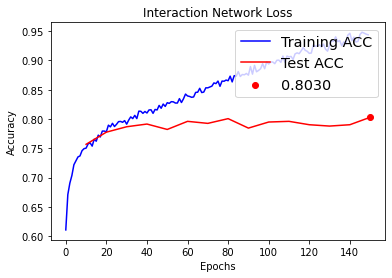

In [3]:
model_args = {"input_node_shape": [None, 14],
              "input_edge_shape": [None, 1],
              "input_embedd": {'input_node_vocab': 55, "input_node_embedd": 64},
              # Output
              "output_embedd": {"output_mode": 'graph', "output_type": 'padded'},
              "output_mlp": {"use_bias": [True, True, False], "units": [140, 70, 1],
                             "activation": ['relu', 'relu', 'sigmoid']},
              # model specs
              "depth": 3,
              "gcn_args": {"units": 64, "use_bias": True, "activation": "relu", "has_unconnected": True,
                           "is_sorted": False, "pooling_method": 'segment_mean'}
              }
model = make_gcn(**model_args)
model_node_weights = make_gcn_node_weights(**model_args)
# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = tf.keras.callbacks.LearningRateScheduler(lr_lin_reduction(learning_rate_start, learning_rate_stop, epomin, epo))
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag_2.png')
plt.show()

## We have to implement the ExplainableGCN from the GNNInterface

In [4]:
class ExplainableGCN(GNNInterface):

    def __init__(self, gnn_model, **kwargs):
        super(ExplainableGCN, self).__init__()

        # Here we modify the gcn model to allow node weights
        self.gnn_model = gnn_model

    def predict(self, gnn_input, masking_info=None):
        node_input, edge_input, edge_index_input = gnn_input
        node_weights = tf.RaggedTensor.from_row_splits(tf.expand_dims(tf.ones_like(node_input.values)[:,0],axis=-1), node_input.row_splits)
        return self.gnn_model([node_input, edge_input, edge_index_input, node_weights], training=False)[0]

    def masked_predict(self, gnn_input, edge_mask, feature_mask, node_mask, training=False):
        node_input, edge_input, edge_index_input = gnn_input

        masked_edge_input = edge_mask * edge_input[0]
        masked_edge_input = tf.RaggedTensor.from_row_splits(masked_edge_input, [0, len(masked_edge_input)])
        masked_feature_input = tf.ragged.map_flat_values(tf.math.multiply, tf.dtypes.cast(node_input, tf.float32),
                                                         tf.transpose(feature_mask))
        node_weights = tf.RaggedTensor.from_row_splits(tf.sigmoid(node_mask), np.array([0, len(node_mask)],dtype=np.int))

        masked_pred = self.gnn_model([masked_feature_input, masked_edge_input, edge_index_input, node_weights],
                                     training=training)[0]
        return masked_pred

    def get_number_of_nodes(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input[0].shape[0]

    def get_number_of_node_features(self, gnn_input):
        node_input, _, _ = gnn_input
        return node_input.shape[2]

    def get_number_of_edges(self, gnn_input):
        _, edge_input, _ = gnn_input
        return edge_input[0].shape[0]

    def get_explanation(self, gnn_input, edge_mask, feature_mask, node_mask):
        edge_relevance = np.array(edge_mask[:, 0])
        node_relevance = np.array(node_mask[:, 0])
        feature_relevance = np.array(feature_mask[:, 0])
        features = np.array(gnn_input[0][0])
        edges = np.array(gnn_input[2][0])
        graph = nx.Graph()
        for i, f in enumerate(features):
            graph.add_node(i, features=f, relevance=node_relevance[i])
        for i, e in enumerate(edges):
            if edge_relevance is None:
                graph.add_edge(e[0], e[1])
            else:
                graph.add_edge(e[0], e[1], relevance=edge_relevance[i])
        return graph, feature_relevance

    def present_explanation(self, explanation, threshold=0.5):
        graph = explanation[0]
        # element_labels = np.array([[ 1,  3,  6,  7,  8,  9, 11, 15, 16, 17, 19, 20, 35, 53]])
        element_labels = ['H', 'Li', 'C', 'N', 'O', 'F', 'Na', 'P', 'S', 'Cl', 'K', 'Ca', 'Br', 'I']
        important_edges = []
        color_map = []
        node_color_map = []
        node_labels = {}
        for (u, v, relevance) in graph.edges.data('relevance'):
            relevance = min(relevance + 0.1, 1.0)
            color_map.append((0, 0, 0, relevance))
        for n, f in graph.nodes.data('features'):
            element = np.argmax(f)
            r, g, b, a = plt.get_cmap('tab20')(element)
            node_color_map.append((r, g, b, graph.nodes[n]['relevance']))
            node_labels[n] = (element_labels[element])
        if np.all(explanation[1] == 1):
            nx.draw_kamada_kawai(graph, edge_color=color_map, labels=node_labels, node_color=node_color_map)
        else:
            f, axs = plt.subplots(2, figsize=(8, 12))
            nx.draw_kamada_kawai(graph, ax=axs[0], edge_color=color_map, labels=node_labels, node_color=node_color_map)
            bar_colors = [plt.get_cmap('tab20')(element) for element in np.arange(14)]
            axs[1].bar(np.array(element_labels), explanation[1], color=bar_colors)

In [5]:
# Transfer weights
model_node_weights.set_weights(model.get_weights())
# Instanciate a Explainable GNN:
explainable_gcn = ExplainableGCN(model_node_weights)

In [6]:
# Find the 100 most mutagenic molecules, according to the GNN:
pred = model.predict(xtest)[:,0]
print(np.argsort(pred)[:100])

# Select instance to explain
instance_index = 297

[333 652 466 336  90  87 848 602 126 500 554 709  63 832 379  35 272 635
 264  85  68 534 478 859 103  43 595 761 779 503  55 412  44 743 753 138
 244 260  58 537 317 653 670 689 543 367 819  26 811 615 512  70  59  27
 805 691 183 452 388 515 176 421 507 196 818  18  15 150 118 467 511 807
 185 116 324  34 703 582 248   0 143 443 281 444 839 410 808 551  51 344
 643 192 461 276 212 862 166 809   9 170]


Setup an GNNExplainer and explain the instance:

In [7]:
compile_options = {'loss': 'binary_crossentropy', 'optimizer': tf.keras.optimizers.Adam(lr=0.1)}
fit_options={'epochs': 100, 'batch_size': 1, 'verbose': 0}
gnnexplaineroptimizer_options = {'edge_mask_loss_weight': 0.005,
                 'edge_mask_norm_ord': 1,
                 'feature_mask_loss_weight': 0.0001,
                 'feature_mask_norm_ord': 1,
                 'node_mask_loss_weight': 0.0001,
                 'node_mask_norm_ord': 1}

explainer = GNNExplainer(explainable_gcn,
                              compile_options=compile_options,
                              fit_options=fit_options,
                              gnnexplaineroptimizer_options=gnnexplaineroptimizer_options)

explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest])
#explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=tf.Variable([0.]))

C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer/model_1/gcn_5/gather_nodes_outgoing_5/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/gnn_explainer_optimizer/model_1/gcn_5/gather_nodes_outgoing_5/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gnn_explainer_optimizer/model_1/gcn_5/gather_nodes_outgoing_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer/model_1/gcn_4/gather_nodes_outgoing_4/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/gnn_explai

<Figure size 432x288 with 0 Axes>

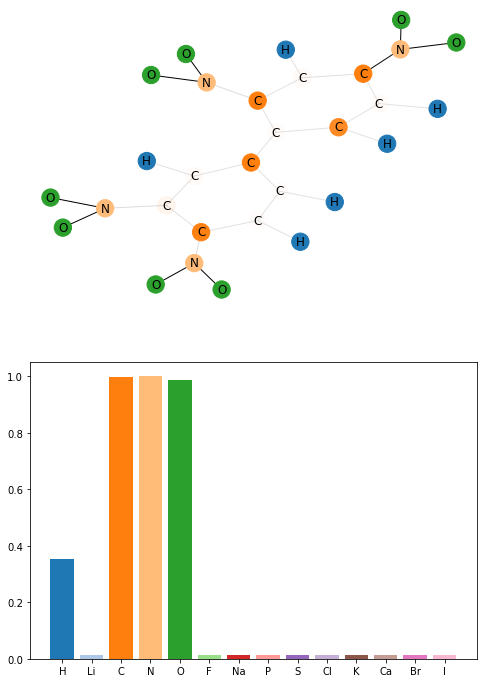

In [8]:
# Let's look at the explanation the GNNExplainer found:
plt.figure()
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()

If we do not specify the output_to_explain as parameter to the explain method the Explainer
will explain why the GNN came to its conclusion.
For molecules which are classified as non-mutagenic by the GNN,
the GNNExplainer will then explain why they are non-mutagenic.
We can also specify output_to_explain to be tf.Variable([0.]).
This way we can tell the Explainer to explain why a molecule could be mutagenic
even for molecules which are classified as most likely non-mutagenic by the GNN):

C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_5/gather_nodes_outgoing_5/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_5/gather_nodes_outgoing_5/Reshape:0", shape=(None, 64), dtype=float32), dense_shape=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_5/gather_nodes_outgoing_5/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\Patrick\.conda\envs\aimat\lib\site-packages\tensorflow\python\framework\indexed_slices.py:435: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gnn_explainer_optimizer_1/model_1/gcn_4/gather_nodes_outgoing_4/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradient_tape/gn

<Figure size 432x288 with 0 Axes>

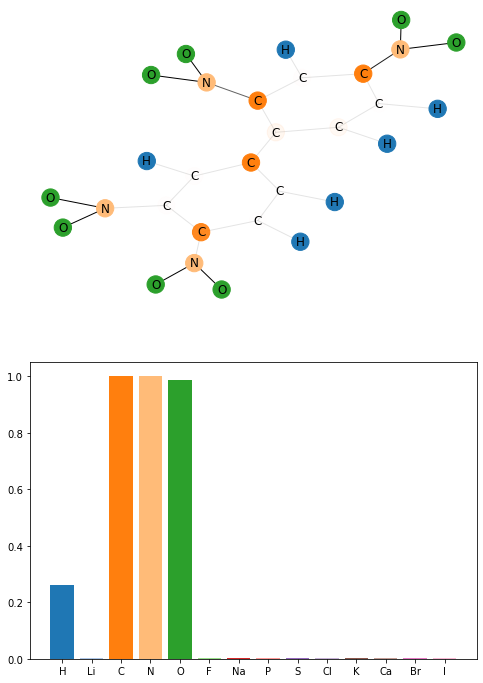

In [9]:
plt.figure()
explainer.explain([tensor[instance_index:instance_index+1] for tensor in xtest], output_to_explain=tf.Variable([0.]))
explainer.present_explanation(explainer.get_explanation(), threshold=0.5)
plt.show()